# <center>Auto Color Scaling</center>

# TLDR;
 * use `plot_by_id(run_id, auto_color_scale=True, cutoff_percentile=(0.5, 0.6)` to enable automatic color scaling
 * this maximally cuts 0.5% of the low valued data points and 0.6% of the high valued data points.
 * You can also use it for `show_num` or for matplotlib with the supplied auto scaling function. 
 * Set your defaults in `qcodesrc.json`.

## Table of contents
1. [Introduction to the problem and risks](#introduction)
2. [Using the automatic color scale](#using)
    1. [Example 1: outliers in homogeneous data](#case1)
3. [Details of the calculation](#details)
4. [Cutoff Percentiles](#percentiles)
    1. [Example 2: data on noisy background with outliers](#case2)
4. [Defaults and customizing the auto color scaling](#customizing)
5. [Using auto color scaling in custom plotting](#custom_plotting)

## Introduction to the problem and risks<a name="introduction"></a>
It is a fairly common annoyance that a heatmap plot of ones dearest data does not show any of its details due to some outliers that push the range of the color scale beyond the desired limits, as it is shown in the image below:
<img width=600em src="files/auto_color_scale_swamped.png">
Here there are two pixels (black and white) corresponding to high and low outliers. The remaining data is uniformly displayed as red and the actual structure of it is drowned. 
One can of course specify the limits of the colorbar manually to v
iew the full structure as shown here:
<img width=600em src="files/auto_color_scale_clean.png">
But for a long measurement series this becomes a time consuming task.


In this notebook an *automatic color scaling* is presented that tries to empower the experimenter to circumvent this difficulty, while keeping possible risks in mind.


The risk narrowing the color scale is clearly that the image representing the data saturates in some regions and is no longer fully representative of the actual data. Especially for automatic color scaling this can become risky because without a theoretical model describing the specific measurement one cannot scientifically argue for the choice of the new limits of the color scale and possible meaningful features might be disregarded.


For this reason automatic colorscaling is deactivated by default and has to be activated manually.

## Using the automatic color scale<a name="using"></a>
The follwing section presents an example of the usage of the automatic color scaling with the new `DataSet` and the `plot_by_id` function for plotting. The same keywords will be implemented by `show_num` from `qdev-wrappers`. Let's first make the neccessary imports:

In [1]:
# store data in a seperate db in order not to spam the actual measurement db
from qcodes import initialise_or_create_database_at, new_data_set, new_experiment
from qcodes.dataset.plotting import plot_by_id
initialise_or_create_database_at('../example.db')

# create an experiment for this tutorial
new_experiment(name='tutorial_auto_color_scale', sample_name="outliers")

# import methods for creating datasets with outliers:
from qcodes.tests.test_plot_utils import (dataset_with_data_outside_iqr_high_outlier,
                                          dataset_with_data_outside_iqr_low_outlier,
                                          dataset_with_outliers)

### Exampe 1: outliers in homogeneous data<a name="case1"></a>
Here we basically reproduce the images of the introduction, where we have some smothly structured data with some outliers that lie far outside of the range of the remaining data:

In [2]:
# create a new dataset with outliers
ds = dataset_with_outliers(new_data_set('data_with_outliers'))

by plotting it simply by `plot_by_id` we get the full range

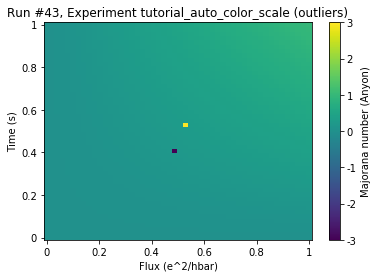

In [4]:
ax, cb = plot_by_id(ds.run_id);

by adding the keyword `auto_color_scale=True` one activates the scaling:

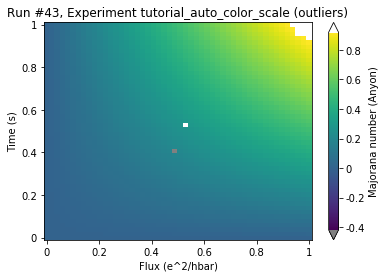

In [5]:
ax, cb = plot_by_id(ds.run_id, auto_color_scale=True);

and the actual structure of the data becomes visible.

Please note two further details:
 - The triangles that appeared at the top and the bottom of the colorbar: These indicate that the colorbar does not cover the full range of the data spectrum.
 - The clipped regions are marked with colors that are clearly not part of the colorscale in order to clearly seperate those regions where we cannot make any claim about any structure
 

 ## Details of the calculation<a name="calculation"></a>
 
The new limits are calculated in three steps:
 -  determine the inter quartile range (IQR), i.e. the distance between the first (q1) and the third (q3) qartile (see image below)
 - expand the region spanned by [q1, q3] by 1.5 x the IQR. (Yet not beyond the original limits of the min/max of the data)
 - limit the amout of data points clipped on each side to an amout that is described by the lower (pl) and upper (pu) cutoff percentiles. E.g. for pu=pl=0.5%, no more the white and grey areas may not take up more than half a percent each of the total area.
 
to understand how this works lets consider the histogram of the previous example:

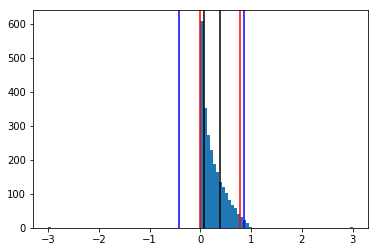

In [6]:
import matplotlib.pyplot as plt
import numpy as np
data = cb[0].mappable.get_array()
pl, q3, q1, pu = np.percentile(data, [97,75, 25, 3])
plt.hist(data, bins=100);
# IQR
plt.axvline(q3, color='k')
plt.axvline(q1, color='k')
# cut off
plt.axvline(q1-1.5*(q3-q1), color='b')
plt.axvline(q3+1.5*(q3-q1), color='b')
# limit through percentiles
plt.axvline(pl, color='r')
plt.axvline(pu, color='r')

The black lines mark q1 and q3 and the blue lines correspond to the interval widened by 1.5x IQR. The red lines present the lines of the percentile cutoff, in this case 3% on each side. The red lines limit how much of the data may be cut away through the blue lines. In this specific case of 3% they are not limiting the cutoff through the IQR estimation. Please also note the barely filled bins at +-10, that represent the outliers. The new color scale therefor roughly corresponds to a threefold increase of the steepness of color gradient.

## Cuttoff Percentiles

Limiting the effect of an automatic color scale by the cutoff percentiles can be very important. To understand thta consider the following example:

### Example 2: data on noisy background with outliers<a name="case2"></a>

In [7]:
# create a new dataset with outliers
ds = dataset_with_data_outside_iqr_high_outlier(new_data_set('data_outside_iqr'))

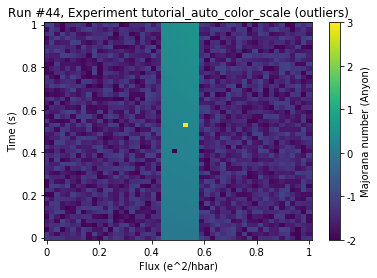

In [8]:
ax, cb = plot_by_id(ds.run_id);

In this example dataset the region of interest shall be represented by the center region. Again there are outliers that render the color grading almost useless.


Looking at the same plot with an automatic color scale without limiting cutoff percentiles (by setting the cutoff to 50%  we basically deactivate them) does not give a better result:

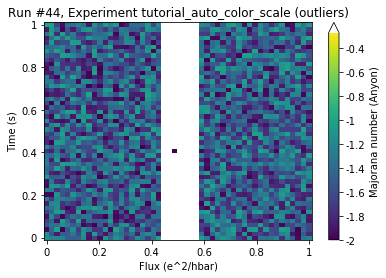

In [9]:
ax, cb = plot_by_id(ds.run_id, auto_color_scale=True, cutoff_percentile=50);

Here all the relevant region is considered as outliers. To make this clearer let's draw the histogram again:

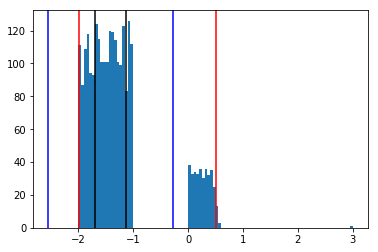

In [10]:
import matplotlib.pyplot as plt
import numpy as np
data = cb[0].mappable.get_array()
pl, q3, q1, pu = np.percentile(data, [99.5,75, 25, 0.5])
plt.hist(data, bins=100);
# IQR
plt.axvline(q3, color='k')
plt.axvline(q1, color='k')
# cut off
plt.axvline(q1-1.5*(q3-q1), color='b')
plt.axvline(q3+1.5*(q3-q1), color='b')
# limit through percentiles
plt.axvline(pl, color='r')
plt.axvline(pu, color='r')

The region of interest is represented by the right hand side structure around 0. The IQR induced limits (blue) does not capture these values. The percentile limits (0.5% here) however save the day:

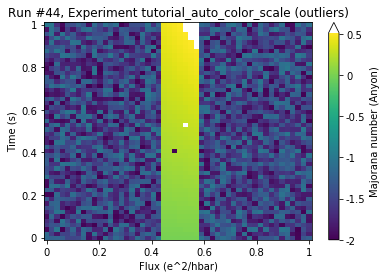

In [11]:
ax, cb = plot_by_id(ds.run_id, auto_color_scale=True, cutoff_percentile=0.5);

There is some undesired clipping in the top right corner of the ROI but the structure within the ROI is relatively well resolved.

### Asymetric cutoffs
Asymmetric cutoffs can be simply defined via a tuples. So for the data of the first example we can disregard the lower outliers that take up up to five percent of the data but not allow any clipping on the upper end:

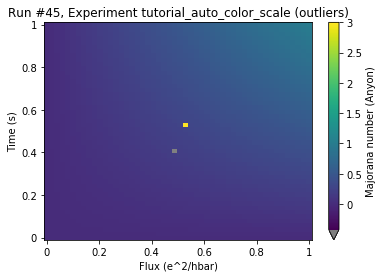

In [12]:
ds = dataset_with_outliers(new_data_set('data_with_outliers'))
ax, cb = plot_by_id(ds.run_id, auto_color_scale=True, cutoff_percentile=(0,5));

## Defaults and customizing the auto color scaling<a name="customizing"></a>
The defaults used by `plot_by_id` and `show_num` can be set in the `qcodesrc.json` files. The system default is described in `qcodes/config/qcodesrc.json` ([offline](../../../qcodes/config/qcodesrc.json),[online](https://github.com/QCoDeS/Qcodes/blob/master/qcodes/config/qcodesrc.json))
To override the default edit these values in your custom `qcodesrc.json` file in your home directory.

The defaults are (for detailed description see the schema file)

Because of the possible risks due to auto colorscaling it is deactivated by default. Please remeber to change the colors marking the outliers in case you should use a color map the includes white and grey.

## Using auto color scaling in custom plotting<a name="custom_plotting"></a>
If you are using matplotlib but do not want to reley on `plot_by_id` or `show_num` you can simply call:
`qcodes.utils.plotting.apply_auto_color_scale(colorbar, ...)` and provide any matplotlib colorbar to achieve the described effects.

If you want to use the qcodes config system for defaults call
`qcodes.utils.plotting.auto_color_scale_from_config(colorbar,...)` instead.